![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## Роман Разумовский на основании baseline notebook от Alex Lekov

# import

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(''): #/kaggle/input
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [13]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [14]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [15]:
DATA_DIR = ''#'/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [17]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [18]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [19]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [20]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [22]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
28237,id_1514,Lyon,NaN,1496.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187265-d8785536-Reviews-Tr...,d8785536,1,5.0
47521,id_7980,Madrid,['Spanish'],7987.0,NaN,32.0,"[[], []]",/Restaurant_Review-g187514-d4545530-Reviews-Ca...,d4545530,1,3.0
44024,id_3195,Barcelona,"['Mediterranean', 'Spanish']",3196.0,$$ - $$$,176.0,"[['Cometacinc revisited', 'Beautiful meal!'], ...",/Restaurant_Review-g187497-d1410541-Reviews-Co...,d1410541,1,3.5
5841,id_5841,Lisbon,"['European', 'Portuguese']",3559.0,$$ - $$$,89.0,"[['Garphus', 'Rip off for very mediocre food']...",/Restaurant_Review-g189158-d6898769-Reviews-Re...,d6898769,0,0.0
42545,id_1012,Hamburg,"['International', 'Mediterranean', 'Sushi', 'G...",1014.0,$$ - $$$,40.0,"[['Best View, Average Food', 'Restaurant with ...",/Restaurant_Review-g187331-d966299-Reviews-Gen...,d966299,1,4.0


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [23]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [24]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [25]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [26]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [27]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [28]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
33186,id_12785,NaN,12795.0,NaN,4.0,"[['late night', 'wonderful service'], ['03/01/...",/Restaurant_Review-g186338-d8659492-Reviews-Gr...,d8659492,1,3.5,...,0,0,0,0,0,0,0,0,0,0
7207,id_7207,['French'],5796.0,NaN,22.0,"[[], []]",/Restaurant_Review-g187147-d3203913-Reviews-Le...,d3203913,0,0.0,...,0,0,1,0,0,0,0,0,0,0
18453,id_1751,"['Cafe', 'European', 'Mediterranean']",1752.0,$,29.0,"[['Great cafe near Passeig de Gracia', 'Cockta...",/Restaurant_Review-g187497-d10223089-Reviews-M...,d10223089,1,5.0,...,0,0,0,0,0,0,0,0,0,0
49127,id_2298,"['French', 'Healthy']",2299.0,$$ - $$$,59.0,"[['A+ Crepes. Best spot for gluten free.', 'Hi...",/Restaurant_Review-g187147-d8617256-Reviews-Bl...,d8617256,1,5.0,...,0,0,1,0,0,0,0,0,0,0
12573,id_4257,"['French', 'Bar', 'European']",4258.0,$$ - $$$,208.0,"[['Love this place!', 'good food, friendly ser...",/Restaurant_Review-g187147-d3364486-Reviews-Au...,d3364486,1,4.0,...,0,0,1,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [30]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [31]:
# Ваша обработка 'Price Range'

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [32]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

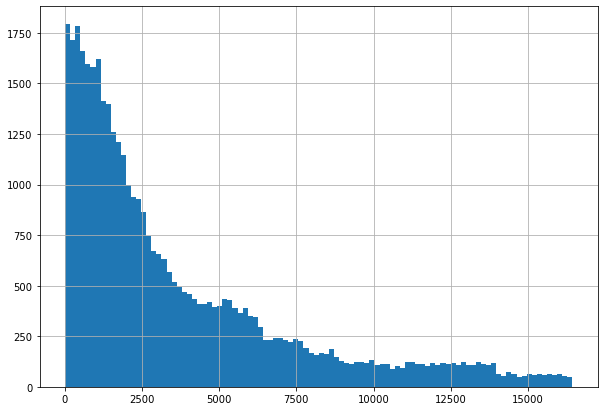

In [33]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

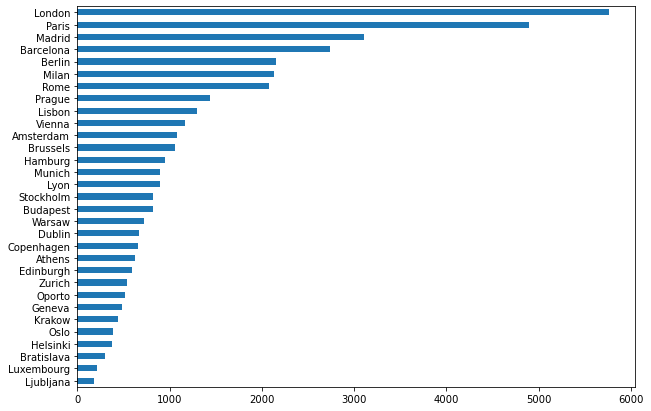

In [34]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

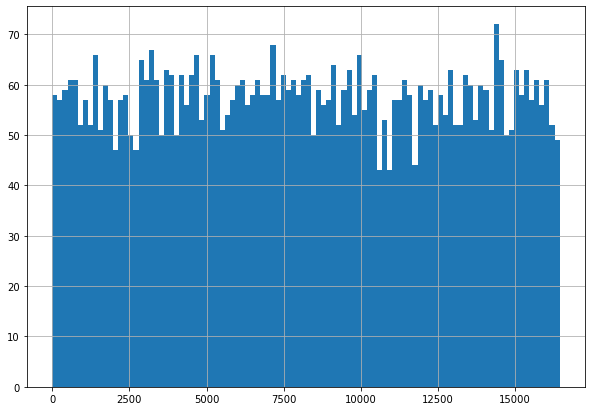

In [35]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

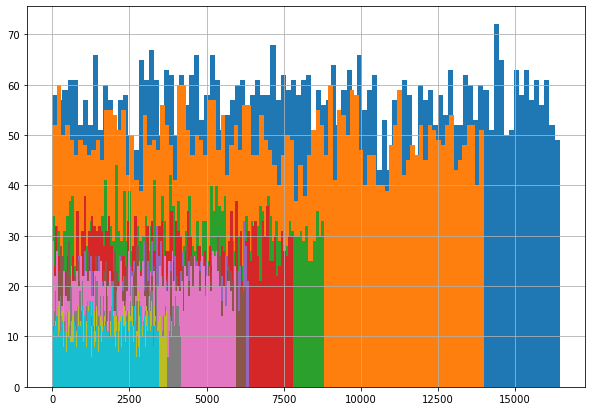

In [36]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

1. Получается, что Ranking имеет равномерное распределение, просто в больших городах больше ресторанов, из-за этого мы имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


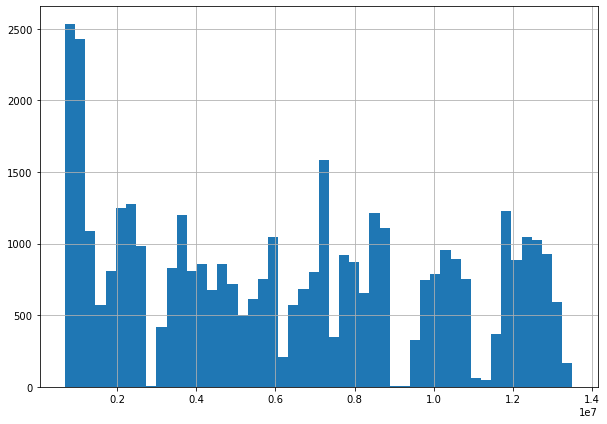

In [37]:
df_train['TA_ID'] = df_train['ID_TA'].apply(lambda x:int(x[1:]))
df_train['TA_ID'].hist(bins=50)

### Посмотрим распределение целевой переменной

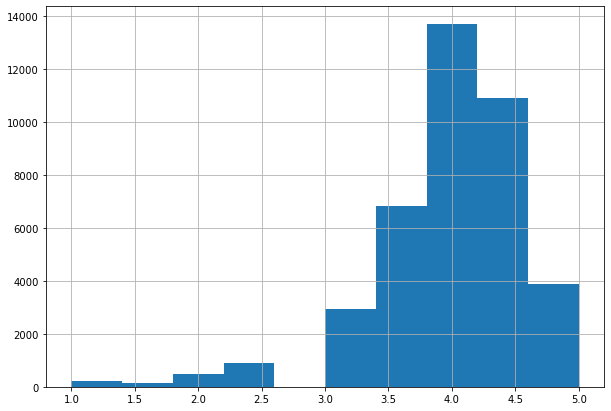

In [38]:
df_train['Rating'].hist()

### Посмотрим распределение целевой переменной относительно признака

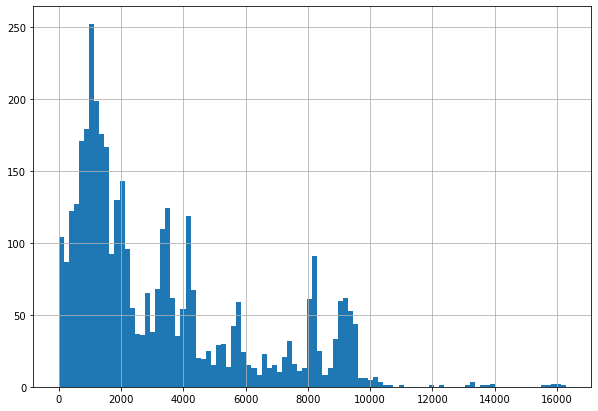

In [39]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

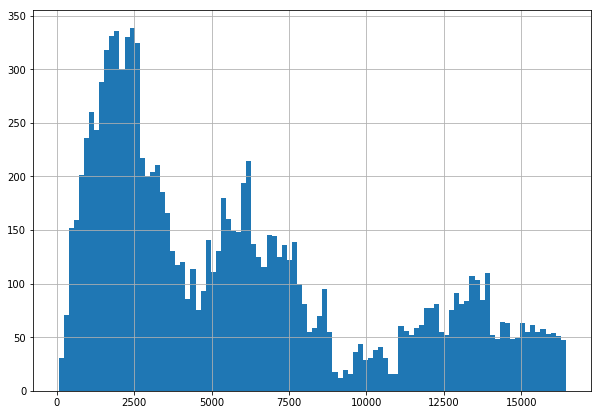

In [34]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

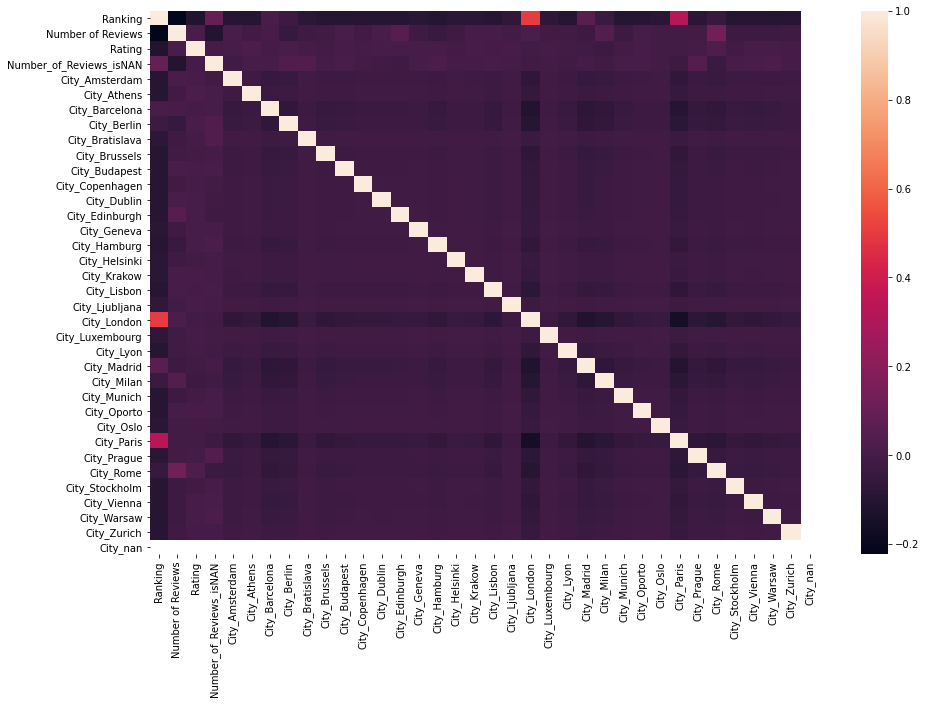

In [40]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [41]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [42]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1


In [43]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    # df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # тут ваш код на Encoding фитчей
    df_output['Price Range'] = df_output['Price Range'].replace({'$':2, '$$ - $$$':1, '$$$$':3, None:0})
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код на генерацию новых фитчей
    # Вычисляем ранг внутри города, нормируя на макимсальное значение в городе
    city_stat = df_output.groupby(['City'])['Ranking'].agg(['max'])
    df_output = df_output.merge(city_stat, on = 'City')
    df_output['Ranking_City'] = df_output['Ranking'] / df_output['max']
    df_output.drop(['max'], axis = 1, inplace=True)
    
    # Вычисляем средний рейтинг по городам
    city_rating = df_output.query('sample == 1').groupby(['City'])['Rating'].agg(['mean']).rename(columns = {'mean':'City_Rating'})
    df_output = df_output.merge(city_rating, on = 'City')
    
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)
    
    # Создаем флаги принадлежности к разным видам кухни
    df_output['Cuisine_count'] = 0
    for i in range(df_output.shape[0]):
        if isinstance(df_output['Cuisine Style'][i], str):
            cuisine = re.findall(r"[^'\[\]]+[^'\[\]]+[^'\[\]]+", df_output['Cuisine Style'][i])
            df_output['Cuisine_count'][i] = len(cuisine)
            for j in cuisine:
                if 'Cuisine: '+j not in df_output.columns:
                    df_output['Cuisine: '+j] = 0
                df_output['Cuisine: '+j][i] = 1
    
    #Выделяем порядковые номера из Restaurant_id, ID_TA, URL_TA
    df_output['Rest_ID'] = df_output['Restaurant_id'].apply(lambda x:int(x[3:]))
    df_output['TA_ID'] = df_output['ID_TA'].apply(lambda x:int(x[1:]))
    df_output['Some_code'] = df_output['URL_TA'].apply(lambda x: int(re.findall(r"Review-.+-d", x)[0][8:-2]) if len(re.findall(r"Review-.+-d", x)) > 0 else 0)
    
    # Записываем отзывы и даты отзывов в отдельные поля. Вычисляем давность отзывов
    df_output['Review_1'] = ''
    df_output['Review_2'] = ''
    df_output['ReviewDate_1'] = np.datetime64('NaT')
    df_output['ReviewDate_2'] = np.datetime64('NaT')
    df_output['Review_count'] = 0
    df_output['Review_1_len'] = 0
    df_output['Review_2_len'] = 0
    rev = [] # Список слов в отзывах
    for i in range(df_output.shape[0]):
        if isinstance(df_output['Reviews'][i], str):
            reviews = re.findall(r"[^'\[\]]+[^'\[\]]+[^'\[\]]+", df_output['Reviews'][i])
            if len(reviews) >= 4:
                df_output['Review_count'][i] = 2
                df_output['Review_1'][i] = reviews[0]
                df_output['Review_2'][i] = reviews[1]
                rev1 = re.findall(r"[\w]+",(reviews[0]).upper())
                rev2 = re.findall(r"[\w]+",(reviews[1]).upper())
                df_output['Review_1_len'][i] = len(rev1)
                df_output['Review_2_len'][i] = len(rev2)
                rev = rev + rev1 + rev2
                try:
                    df_output['ReviewDate_1'][i] = max(datetime.strptime(reviews[-1],'%m/%d/%Y'),datetime.strptime(reviews[-2],'%m/%d/%Y'))
                    df_output['ReviewDate_2'][i] = min(datetime.strptime(reviews[-1],'%m/%d/%Y'),datetime.strptime(reviews[-2],'%m/%d/%Y'))
                except ValueError:
                    df_output['ReviewDate_1'][i] = datetime.strptime(reviews[-1],'%m/%d/%Y')
            elif len(reviews) >= 2:
                df_output['Review_count'][i] = 1
                df_output['Review_1'][i] = reviews[0]
                rev1 = re.findall(r"[\w]+",(reviews[0]).upper())
                df_output['Review_1_len'][i] = len(rev1)
                rev = rev + rev1
                df_output['ReviewDate_1'][i] = datetime.strptime(reviews[-1],'%m/%d/%Y')
    
    df_output['ReviewDist'] = (df_output['ReviewDate_1'] - df_output['ReviewDate_2']).apply(lambda x:x.days).fillna(-1)
    df_output['Review_1_age'] = (df_output['ReviewDate_1'].max() - df_output['ReviewDate_1']).apply(lambda x:x.days).fillna(300)
    df_output['Review_2_age'] = (df_output['ReviewDate_2'].max() - df_output['ReviewDate_2']).apply(lambda x:x.days).fillna(300)
    
    # Создаем переменные для топ-слов в отзывах
    rev_top = list(pd.Series(rev).value_counts().nlargest(50).index)
    for i in rev_top:
        df_output['Review: '+i] = 0
    for i in range(df_output.shape[0]):
        if isinstance(df_output['Review_1'][i], str) or isinstance(df_output['Review_2'][i], str):
            words = re.findall(r"[\w]+",(df_output['Review_1'][i]+' '+df_output['Review_2'][i]).upper())
            for j in words:
                if j in rev_top:
                    df_output['Review: '+j][i] = 1
    
    # Вычисляем суммы по "лучшим" и "худшим" отзывам и кухням 
    
    reviews = [col for col in df_output.columns if 'Review: ' in col]
    corr = df_output[['Rating']+reviews].corr()['Rating'].sort_values()
    good_review = list(corr[(corr > 0.02) & (corr < 1)].index)
    bad_review = list(corr[corr < -0.02].index)
    df_output['Review: emotion'] = df_output[good_review].sum(axis=1) - df_output[bad_review].sum(axis=1)

    cuisine = [col for col in df_output.columns if 'Cuisine: ' in col]
    corr = df_output[['Rating']+cuisine].corr()['Rating'].sort_values()
    good_cuisine = list(corr[(corr > 0.02) & (corr < 1)].index)
    bad_cuisine = list(corr[corr < -0.02].index)
    df_output['Cuisine: emotion'] = df_output[good_cuisine].sum(axis=1) - df_output[bad_cuisine].sum(axis=1)
    
    # ################### 5. Clean #################################################### 
    # Восстанавливаем исходную сортировку
    df_output = df_output.sort_values(by=['sample', 'Rest_ID'])
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object' \
                      or df_output[s].dtypes == np.dtype('<M8[ns]') or s == 'Rest_ID']# or s == 'Ranking' or s == 'Number of Reviews']
    #and s != 'Review_1' and s != 'Review_2'
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [44]:
# Прожорливый вызов: на Kaggle крутится несколько минут, на менее мощном железе может работать существенно дольше
df_preproc = preproc_data(data)
df_preproc = df_preproc.reset_index(drop=True)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Ranking_City,City_Rating,City_Amsterdam,City_Athens,City_Barcelona,...,Review: YOU,Review: FANTASTIC,Review: IS,Review: AUTHENTIC,Review: AVERAGE,Review: QUICK,Review: QUALITY,Review: PERFECT,Review: emotion,Cuisine: emotion
1670,5547.0,0,4.0,0,0.0,0.932582,4.230269,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25353,1582.0,2,108.0,1,4.0,0.252112,3.824895,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20606,1034.0,0,20.0,1,4.0,0.387847,3.948430,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48897,13641.0,0,4.0,1,3.5,0.829543,3.955098,0,0,0,...,0,0,0,0,0,0,0,0,1,0
40339,5389.0,0,2.0,1,3.5,0.845731,4.124594,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16969,659.0,2,61.0,1,4.0,0.368774,4.230096,0,1,0,...,0,0,0,0,1,0,0,0,-1,2
614,14487.0,1,82.0,0,0.0,0.880990,3.955098,0,0,0,...,0,0,0,0,0,0,0,1,0,0
35747,3634.0,0,2.0,1,5.0,0.412533,3.800837,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14620,433.0,1,43.0,1,4.5,0.158202,4.021075,0,0,0,...,0,0,0,0,0,0,0,0,1,0
27519,1882.0,2,140.0,1,4.0,0.299920,3.824895,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 225 entries, Ranking to Cuisine: emotion
dtypes: float64(8), int64(185), uint8(32)
memory usage: 75.1 MB


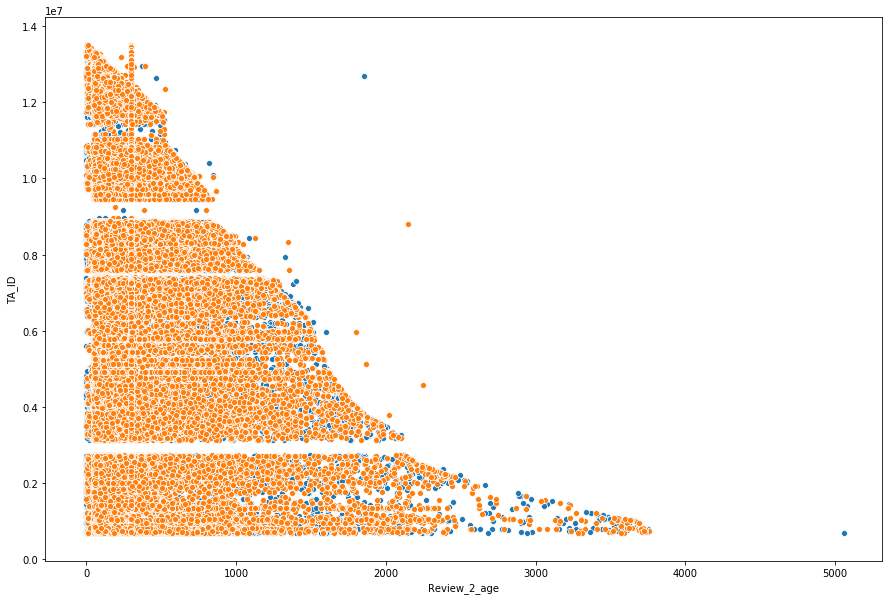

In [44]:
sns.scatterplot(x = df_preproc['Review_1_age'], y = df_preproc['TA_ID'])
sns.scatterplot(x = df_preproc['Review_2_age'], y = df_preproc['TA_ID'])

In [45]:
#df_age = df_preproc.sort_values(by='TA_ID',ascending=False)[['Review_1_age','Review_2_age']].rolling(500).quantile(0.995).fillna(1).sort_index()\
#    .rename(columns = {'Review_1_age':'Rest_age_1','Review_2_age':'Rest_age_2'})
#df_preproc = pd.merge(df_preproc, df_age, left_index = True, right_index = True)
#df_preproc['Review_frequency'] = df_preproc['Number of Reviews'] / df_preproc['Rest_age_2']
#df_preproc['Review_smth'] = df_preproc['Number of Reviews'] / df_preproc['Review_1_age'].apply(lambda x: x if x>0 else 1)
#tst['Interest'][tst['Interest']<1].hist()
#sns.scatterplot(x = tst['Rest_age_2'], y = tst['TA_ID'])
#sns.scatterplot(x = tst['Review_2_age'], y = tst['TA_ID'])

In [46]:
#df_preproc[df_preproc['sample']==1][['Rating','TA_ID','Rest_age_2','Review_1_age','Review_2_age','ReviewDist','Review_frequency','Review_1_len']].corr()

In [47]:
#df_preproc['rev by rank'] = df_preproc['Number of Reviews'] * df_preproc['Ranking_City']

In [48]:
#Добавим полиномы от интервальных переменных с множеством значений
from sklearn.preprocessing import PolynomialFeatures
trans = PolynomialFeatures(degree=3)
poly = pd.DataFrame(trans.fit_transform(df_preproc[['Number of Reviews','Ranking_City','TA_ID','Some_code']]))

In [49]:
df_preproc = pd.merge(df_preproc, poly, left_index = True, right_index = True)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [50]:
# Теперь выделим тестовую часть
exclusion = ['sample','Ranking']
train_data = df_preproc.query('sample == 1').drop(exclusion, axis=1)
test_data = df_preproc.query('sample == 0').drop(exclusion, axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 258), (40000, 258), (40000, 257), (32000, 257), (8000, 257))

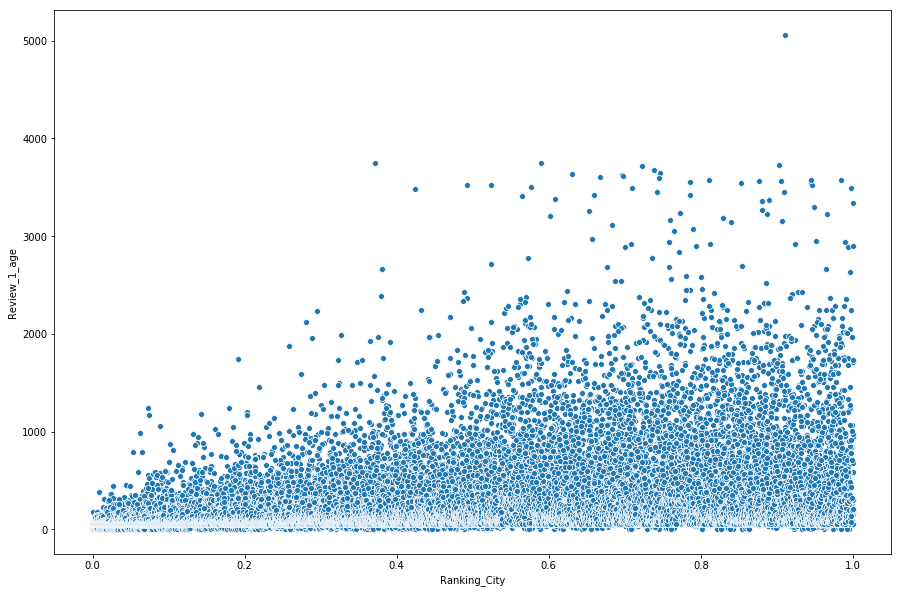

In [51]:
sns.scatterplot(x = train_data['Ranking_City'], y = train_data['Review_1_age'])

# Model 
Сам ML

In [52]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn import tree

In [53]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [54]:
# Функция для округления прогноза модели до ближайшего полуцелого числа
def semiround(x):
    return np.array([np.round(xi * 2) / 2 for xi in x])

In [55]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения на train записываем в переменную y_dev, на test - в y_pred
y_pred = model.predict(X_test)
y_pred = semiround(y_pred)
y_dev = model.predict(X_train)
y_dev = semiround(y_dev)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


In [56]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE train:', metrics.mean_absolute_error(y_train, y_dev))
print('MAE test:', metrics.mean_absolute_error(y_test, y_pred))

MAE train: 0.01375
MAE test: 0.160125


0.8453180796460038


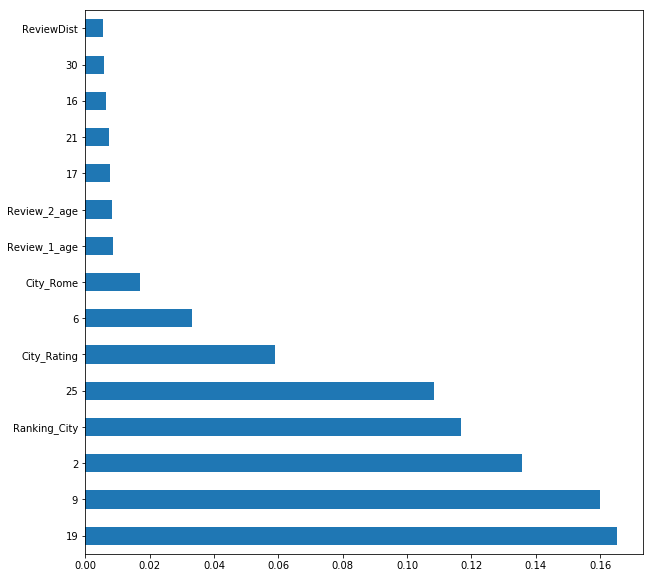

In [57]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
print(feat_importances.nlargest(15).sum())

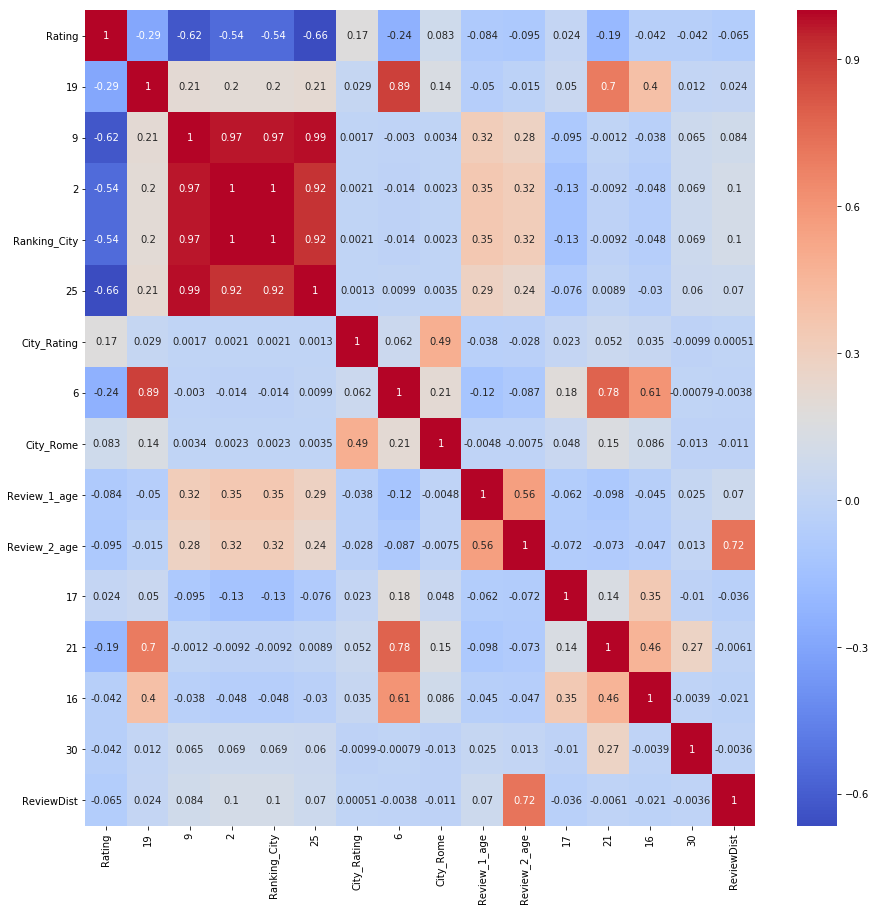

In [58]:
# Несмотря на зашкаливающие корреляции, исключение степеней увеличивает итоговый MAE и локально, и на leaderboard
fig, ax = plt.subplots(figsize = (15,15))
ax = sns.heatmap(train_data[['Rating']+list(feat_importances.nlargest(15).index)].corr(), annot = True, cmap = 'coolwarm')

# Submission
Если все устраевает - готовим Submission на кагл

In [61]:
test_data.sample(10)

,Price Range,Number of Reviews,Rating,Ranking_City,City_Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,25,26,27,28,29,30,31,32,33,34
2291,0,2.0,0.0,0.567393,4.046154,0,0,0,0,0,...,0.182664,2.453885e+06,60896.558657,3.296524e+13,8.180782e+11,2.030175e+10,4.428517e+20,1.098998e+19,2.727316e+17,6.768215e+15
709,0,6.0,0.0,0.869338,3.800837,0,0,0,0,0,...,0.657001,2.045415e+06,141713.492813,6.367908e+12,4.411908e+11,3.056723e+10,1.982495e+19,1.373541e+18,9.516372e+16,6.593274e+15
9700,1,3.0,0.0,0.574706,4.230096,0,1,0,0,0,...,0.189818,3.926466e+06,62556.401280,8.122057e+13,1.294005e+12,2.061607e+10,1.680081e+21,2.676703e+19,4.264519e+17,6.794225e+15
7102,1,136.0,0.0,0.209378,4.089409,0,0,0,0,0,...,0.009179,2.015314e+05,12049.441228,4.424794e+12,2.645557e+11,1.581763e+10,9.715012e+19,5.808546e+18,3.472894e+17,2.076422e+16
5028,1,106.0,0.0,0.237952,3.942414,0,0,0,0,0,...,0.013473,2.098623e+05,10596.500358,3.268884e+12,1.650546e+11,8.334039e+09,5.091721e+19,2.570944e+18,1.298137e+17,6.554636e+15
3880,0,6.0,0.0,0.798230,3.961229,0,0,1,0,0,...,0.508609,8.037349e+06,119467.634438,1.270111e+14,1.887901e+12,2.806187e+10,2.007108e+21,2.983377e+19,4.434509e+17,6.591480e+15
3585,2,25.0,0.0,0.459246,3.946809,0,0,0,0,0,...,0.096858,1.844176e+06,40058.436972,3.511298e+13,7.627099e+11,1.656727e+10,6.685488e+20,1.452195e+19,3.154398e+17,6.851855e+15
4068,0,0.0,0.0,0.527003,4.078045,0,0,0,0,0,...,0.146366,2.011562e+06,52895.298406,2.764564e+13,7.269594e+11,1.911585e+10,3.799441e+20,9.990868e+18,2.627161e+17,6.908286e+15
9601,1,274.0,0.0,0.272829,3.824895,0,0,0,0,0,...,0.020308,1.630958e+05,13982.632643,1.309832e+12,1.122953e+11,9.627373e+09,1.051934e+19,9.018503e+17,7.731799e+16,6.628674e+15
5840,0,0.0,0.0,0.749726,4.021075,0,0,0,0,0,...,0.421413,2.075862e+06,105296.702160,1.022561e+13,5.186873e+11,2.631006e+10,5.037096e+19,2.555033e+18,1.296023e+17,6.573989e+15


In [62]:
test_data = test_data.drop(['Rating'], axis=1)

In [63]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [64]:
predict_submission = model.predict(test_data)
predict_submission = semiround(predict_submission)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [65]:
test_data

,Price Range,Number of Reviews,Ranking_City,City_Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,25,26,27,28,29,30,31,32,33,34
0,1,4.0,0.926855,3.942414,0,0,0,0,0,0,...,0.796225,9.232258e+06,160770.685653,1.070483e+14,1.864141e+12,3.246218e+10,1.241229e+21,2.161478e+19,3.764001e+17,6.554636e+15
1,1,97.0,0.092901,3.946809,0,0,0,0,0,0,...,0.000802,5.760870e+04,1639.242315,4.139191e+12,1.177797e+11,3.351395e+09,2.974013e+20,8.462486e+18,2.407981e+17,6.851855e+15
2,1,28.0,0.458664,4.088087,0,0,0,0,0,0,...,0.096490,2.762113e+06,39239.700861,7.906783e+13,1.123270e+12,1.595763e+10,2.263384e+21,3.215456e+19,4.568008e+17,6.489499e+15
3,3,202.0,0.101496,3.955098,0,0,0,0,0,0,...,0.001046,7.009272e+03,1919.548842,4.698932e+10,1.286843e+10,3.524128e+09,3.150108e+17,8.626840e+16,2.362534e+16,6.470000e+15
4,3,162.0,0.041620,3.970100,0,0,0,0,1,0,...,0.000072,1.926828e+03,476.225427,5.149748e+10,1.272787e+10,3.145758e+09,1.376351e+18,3.401721e+17,8.407528e+16,2.077964e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,28.0,0.265568,3.955098,0,0,0,0,0,0,...,0.018730,8.404504e+05,13141.740203,3.771351e+13,5.897090e+11,9.221012e+09,1.692318e+21,2.646200e+19,4.137743e+17,6.470000e+15
9996,1,2.0,0.702717,4.046154,0,0,0,0,0,0,...,0.347010,6.272213e+06,93408.400739,1.133704e+14,1.688359e+12,2.514375e+10,2.049173e+21,3.051714e+19,4.544739e+17,6.768215e+15
9997,0,2.0,0.886375,3.824895,0,0,0,0,0,0,...,0.696389,1.036929e+07,147585.399840,1.543996e+14,2.197560e+12,3.127772e+10,2.299024e+21,3.272185e+19,4.657279e+17,6.628674e+15
9998,0,2.0,0.639044,3.824895,0,0,0,0,0,0,...,0.260971,1.577485e+06,76713.212931,9.535390e+12,4.637068e+11,2.255010e+10,5.763837e+19,2.802959e+18,1.363081e+17,6.628674e+15


In [66]:
df_test

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,id_9995,London,"['Caribbean', 'Barbecue', 'Jamaican', 'Vegetar...",4367.0,$,28.0,[['By far best Chicken burgers and wings in L....,/Restaurant_Review-g186338-d11916827-Reviews-C...,d11916827,0,0
9996,id_9996,Lisbon,"['Indian', 'Asian', 'Nepali', 'Bangladeshi']",2612.0,$$ - $$$,2.0,"[['Ok indian food'], ['11/25/2017']]",/Restaurant_Review-g189158-d12701633-Reviews-C...,d12701633,0,0
9997,id_9997,Milan,NaN,5562.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d13198194-Reviews-Q...,d13198194,0,0
9998,id_9998,Milan,['Italian'],4010.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d3862815-Reviews-La...,d3862815,0,0


In [67]:
predict_submission

array([3. , 4.5, 4. , ..., 3. , 4.5, 4.5])

In [68]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.0
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


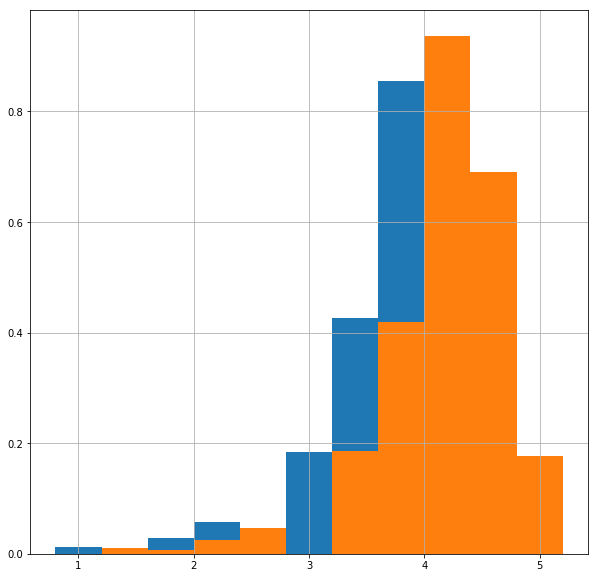

In [69]:
train_data['Rating'].hist(bins=10, density=1, align='left')
sample_submission['Rating'].hist(bins=10, density=1, align='right')
plt.show()

In [70]:
print(train_data['Rating'].value_counts())
print(sample_submission['Rating'].value_counts())

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64
4.0    3745
4.5    2765
3.5    1674
3.0     743
5.0     711
2.5     189
2.0     100
1.0      44
1.5      29
Name: Rating, dtype: int64


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
